Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Alejandro Puerto Castro"
COLLABORATORS = "Gonzalo Peraza"

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Density based clustering

*Note: Text in this notebook is mostly taken as is from references listed at the bottom.*

In this framework, clusters are considered as regions in the l-dimensional space that
are "dense" in points of X. Most of the density-based
algorithms do not impose any restrictions to the shape of the resulting clusters.
Thus, these algorithms have the ability to recover arbitrarily shaped clusters. In
addition, they are able to handle efficiently the outliers. Moreover, the time complexity of these algorithms is lower than $O(N^2)$, which makes them eligible for
processing large data sets.



We'll test our algorithms with the synthetic data from the HDBSCAN python implementation. This data set has 6 natural non-isotropic clusters of different densities, plus noise.

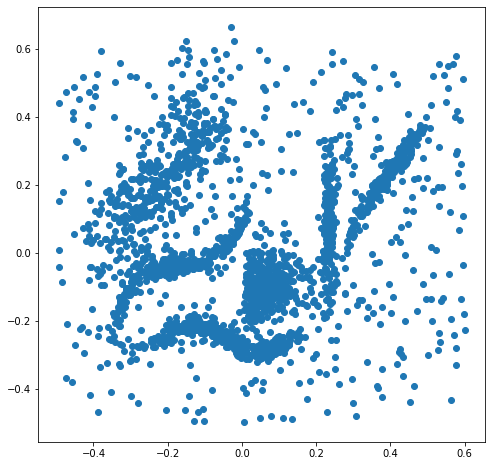

In [3]:
X = np.load('clusterable_data.npy')
figure = plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1]);

## DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

The "density" as it is considered in DBSCAN around a point $x$ is estimated as the number of points in
$X$ that fall inside a certain region in the l-dimensional space surrounding $x$. In the
sequel, we will consider this region to be a hypersphere $V_\epsilon(x)$ centered at $x$, whose
radius $\epsilon$ is a user-defined parameter. In addition, let $N_\epsilon(x)$ denote the number of
points of $X$ lying in $V_\epsilon(x)$. An additional user-defined parameter is the minimum
number of points, $q$, that must be contained in $V_\epsilon(x)$,in order for $x$ to be considered
an "interior" point of a cluster. Before we proceed, the following definitions are in
order.

A point $y$ is **directly density reachable** from a point $x$ if
1. $y \in V_\epsilon(x)$ and
2. $N_\epsilon (x) \geq q$.

In the figure, assuming that $q=5$, $y$ is directly density reachable from $x$, but not vice versa:

![](Figures/ddr.png)

In [4]:
# To find wether a point is a core point or not, we need to find its neighborhood.
# Implement such function below.
def eps_neighborhood(i, X, e):
    """ Returns indices of all points whose distance to X[i] is less than e."""
    
    # YOUR CODE HERE
    distances = np.linalg.norm(X - X[i], axis=1)
    n_list = np.asarray([distance <= e for distance in distances])
    n_list[i] = False
    n_list = np.nonzero(n_list)
    #raise NotImplementedError()
    
    return n_list[0]

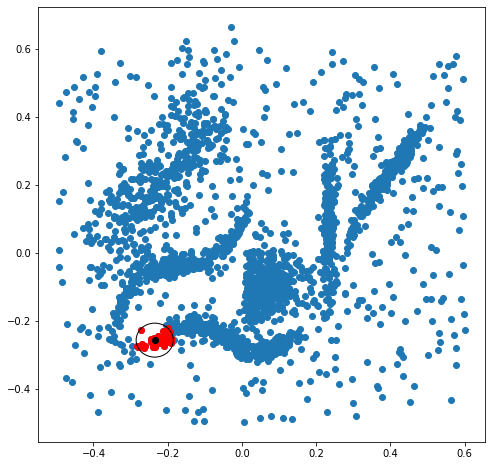

In [5]:
x_idx = 100
e=0.05
nn = eps_neighborhood(x_idx, X, e)
figure = plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[nn][:,0], X[nn][:,1], c='r')
plt.scatter(X[x_idx][0], X[x_idx][1], c='k')
circle = plt.Circle((X[x_idx][0], X[x_idx][1]),radius=e, fill=False)
ax=plt.gca()
ax.add_patch(circle)

A point $y$ is **density reachable** from a point $x$ in $X$ if there is a
sequence of points $x_1 , x_2 , \ldots, x_p \in X$, with $x_1 = x$, $x_p = y$, such that $x_{i+1}$ is
directly density reachable from $x_i$. 

![](Figures/dr.png)

It is easy to note that if $x$ and $y$ in the previous definition are "dense enough" (that is, $N_\epsilon (x) \geq q$ 
and $N_\epsilon (y) \geq q$), the density reachability property is symmetric.
On the other hand, symmetry is lost in the case where either of the points, $x$ and
$y$, has less than $q$ points in its neighborhood. However, in this case there must be a
third point $z \in X$ such that both $x$ and $y$ are density reachable from $z$. This leads
to the definition of the density-connectivity.

A point $x$ is **density connected** to a point $y \in X$ if there exists
$z \in X$ such that both $x$ and $y$ are density reachable from $z$.

![](Figures/dc.png)

After the previous definitions, a **cluster** $C$ in the DBSCAN framework is defined
as a nonempty subset of $X$ satisfying the following conditions:
1. If $x$ belongs to $C$ and $y \in X$ is density reachable from $x$, then $y \in C$.
2. For each pair $(x, y) \in C$, $x$ and $y$ are density connected.

Let $C_1 ,\ldots , C_m$ be the clusters in $X$. Then, the set of points that are not contained
in any of the clusters $C_1 ,\ldots , C_m$ is known as **noise**.

In the sequel, we define a point $x$ as a **core point** if it has at least $q$ points in
its neighborhood. Otherwise, $x$ is said to be a **noncore point**. A noncore point
may be either a **border point** of a cluster (that is, density reachable from a core
point) or a **noise point** (that is, not density reachable from other points in $X$).
Having established the previous definitions, the following two propositions hold
true:

- **Proposition 1**. If $x$ is a core point and $D$ is the set of points in $X$ that are density reachable from $x$, then $D$ is a cluster.

- **Proposition 2**. If $C$ is a cluster and $x$ a core point in $C$, then $C$ equals to the set of the points $y \in X$ that are density reachable from $x$.

These two propositions imply that a cluster is uniquely determined by any of its core points. 

In [6]:
# We now need a function to grow a cluster.
# Implement a function that starts at a core point and finds all density reachable points from it, 
# and adds them to the cluster.
def grow_cluster(i, X, e, q, labels, m):
    """ Starts at core point X[i] and finds all density connected points to it.
        INPUTS:
            i: index of seed point
            X: data matrix
            e: neighbor radius
            q: min points in neighborhood to be considered core point
            labels: list of cluster labels
            m: current cluster label
        OUTPUTS:
            number of points in new cluster
            
        To implement this function try to build up a FIFO queu. Start your queue 
        with the intial neighbors, then test each neighbor to know wether is a core point or not.
        If the neighbor is a core point add its neighbors to the queue, else do nothing as it is a boundary point.
        
        The queu will grow with each new core point's neighbors, until all density connected points are tested.
    """
    
    # Append i to cluster
    labels[i] = m
    
    # Create a FIFO list to queu potential new core points to test.
    queue = list(eps_neighborhood(i, X, e))
        
    # For each point in queu, search its neighborhood, and new core points to queu.
    j = 0
    while j < len(queue):
        # YOUR CODE HERE
        #If queue point is nosie, add it to cluster, not a core point
        cluster_idx = queue[j] #cluster -> idx
        if labels[cluster_idx] == -1:
            labels[cluster_idx] = m
        #If not already in a cluster, add to cluster and test for core point
        elif labels[cluster_idx] == 0:
            labels[cluster_idx] = m
            neighbors = eps_neighborhood(cluster_idx, X, e)
            if len(neighbors) >= q: #New core point, must add neighbors to queue
                queue += list(neighbors)
        #raise NotImplementedError()
        j += 1
    
    # return size of cluster, just to return a value
    return len(queue)

Cluster size obtained: 8993, should be 8993


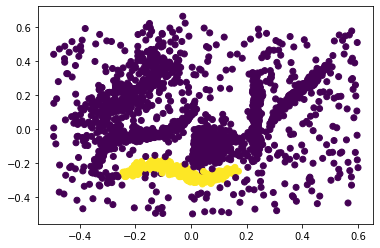

In [7]:
labels = np.zeros(len(X))
size = grow_cluster(100, X, 0.02, 5, labels, 1)
plt.scatter(X[:,0], X[:,1], c=labels)
print(f'Cluster size obtained: {size}, should be {8993}')

We proceed now with the description of the DBSCAN algorithm. Let $X_{un}$ be the set of points in $X$ that have
not been considered yet, and let $m$ denote the number of clusters.

1. Set $X_{un} = X$
2. Set $ m = 0$
3. While $X_{un} \neq \emptyset$ do
    1. Arbitrarily select a $x \in X_{un}$.
    2. If $x$ is a noncore point then
        1. Mark $x$ as noise point.
        2. $X_{un} = X_{un} - \{x\}$
    3. If $x$ is a core point then
        1. $m = m + 1$
        2. Determine all density-reachable points in $X$ from $x$.
        3. Assign $x$ and the previous points to the cluster $C_m$. The border points that may have been marked as noise are also assigned to $C_m$.
        4. $X_{un} = X_{un} - C_m$
        
A delicate point of the algorithm is the following. Suppose that a border point $y$ of
a cluster $C$ has currently been selected by the algorithm. This point will be marked
as a noise point, through the first branch of the if statement of the algorithm. Note,
however, that when, later on, a core point $x$ of $C$ will be considered from which $y$
is density reachable, then $y$ will be identified as a density-reachable point from $x$
and will be assigned to $C$. On the other hand, if $y$ is a noise point it will be marked
as such and because it is not density reachable by any of the core points in $X$ its
"noise" label will remain unaltered.

In [8]:
def dbscan(X, e, q):
    """ The DBSCAN algorithm. Unoptimized implementation with pedagogical purposes.
        
        INPUTS:
                -X: data matrix
                -e: epsilon, the neighbor radius arround each point
                -q: The minimum number of points for a cluster to be dense
    """
    
    n, d = X.shape
    # Array to hold cluster assignments: 0 is not considered, -1 is noise
    # You need to return this array correctly
    labels = np.zeros(n)
    
    # Current cluster label
    m = 0
    
    # Instead of using sets, well just iterate over every point in order.
    # If you want to choose at random, you can shuffle X before starting.
    # I don't beleive it makes a difference
    for i, x in enumerate(X):
        if labels[i] != 0:
            # Point already in another cluster
            continue
        nbrs = eps_neighborhood(i, X, e)
        if len(nbrs) < q:
            # Is a noise point (so far, can be claimed later.)
            labels[i] = -1
            continue
        # else, x is a core point
        m += 1
        m_size = grow_cluster(i, X, e, q, labels, m)
        
    return labels

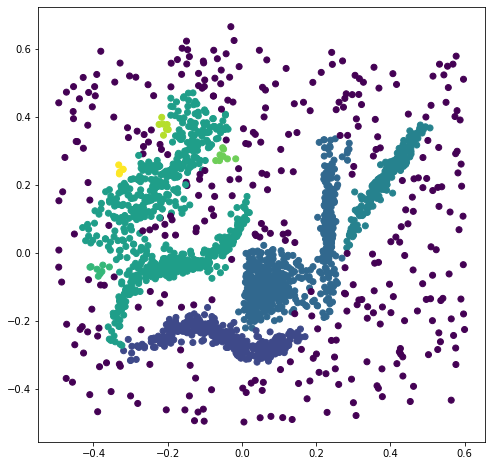

In [9]:
# Now test different values of e and q.
# A good choice seems to be e = 0.025 and q = 4.
labels = dbscan(X, 0.025, 4)
figure = plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=labels);

### Remarks
- The results of the algorithm are greatly influenced by the choice of $\epsilon$ and $q$. Different values of the parameters may lead to totally different results. One should select these parameters so that the algorithm is able to detect the least "dense" cluster. In practice, one has to experiment with several values for $\epsilon$ and $q$ in order to identify their "best" combination for the data set at hand.

- Implementation of the algorithm by adopting the $R^∗$-tree data structure can achieve time complexity of $O(N log_2 N )$ for low-dimensional data sets.

- The DBSCAN is not appropriate for cases where the clusters in $X$ exhibit significant differences in density, and it is not well suited for high-dimensional data.

## OPTICS (Ordering Points To Identify the Clustering Structure)

An extension of DBSCAN that overcomes the necessity of choosing carefully the
parameters $\epsilon$ and $q$. This generates a density-based cluster ordering,
representing the intrinsic hierarchical cluster structure of the data set in a comprehensible form. Experiments indicate that the run time of OPTICS is roughly equal to 1.6 of the runtime required by DBSCAN. On the other
hand, in practice one has to run DBSCAN more than one time for different values
of $\epsilon$ and $q$.

## Mean Shift

## HDBSCAN

Video introducing a fast HDBSCAN implementation with a good explanation of the algorithm: https://www.youtube.com/watch?v=dGsxd67IFiU.

Documentation from HDBSCAN implementation from the video: https://hdbscan.readthedocs.io/en/latest/index.html

A nice blog post: https://towardsdatascience.com/understanding-hdbscan-and-density-based-clustering-121dbee1320e

### Assignment

Watch video, read documentation. Then try HDBSCAN with the same sample dataset. Compare.

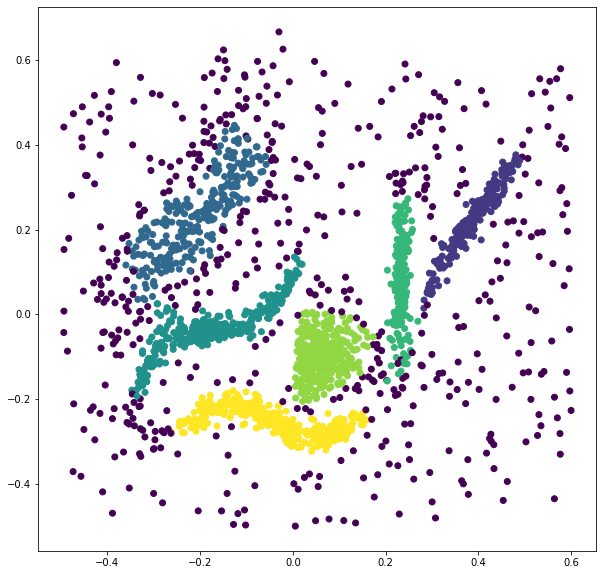

In [10]:
# Write your code here, add cells if needed.
import hdbscan

# YOUR CODE HERE
clusterer = hdbscan.HDBSCAN(min_cluster_size=15)
clusterer.fit(X)
labels = clusterer.labels_

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(X[:,0], X[:,1], c=labels)
plt.show()
#raise NotImplementedError()

## DENCLUE

Quick overview of DENCLUE: https://wiki.ubc.ca/Course:CPSC522/Density-Based_Unsupervised_Learning

## References
- Pattern Recognition, Theodoris and Koutroumbas